# dataset link: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

In [ ]:
# !unzip archive.zip -d ultrasound_data/

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_dir = "ultrasound_data/Dataset_BUSI_with_GT"
print("No of images for benign:", len(os.listdir((os.path.join(base_dir, "benign")))))
print("No of images for malignant:", len(os.listdir((os.path.join(base_dir, "malignant")))))
print("No of images for normal:", len(os.listdir((os.path.join(base_dir, "normal")))))

No of images for benign: 891
No of images for malignant: 421
No of images for normal: 266


🧾 Image Counts:
- benign: 437 images
- malignant: 210 images
- normal: 133 images

📁 Class: benign


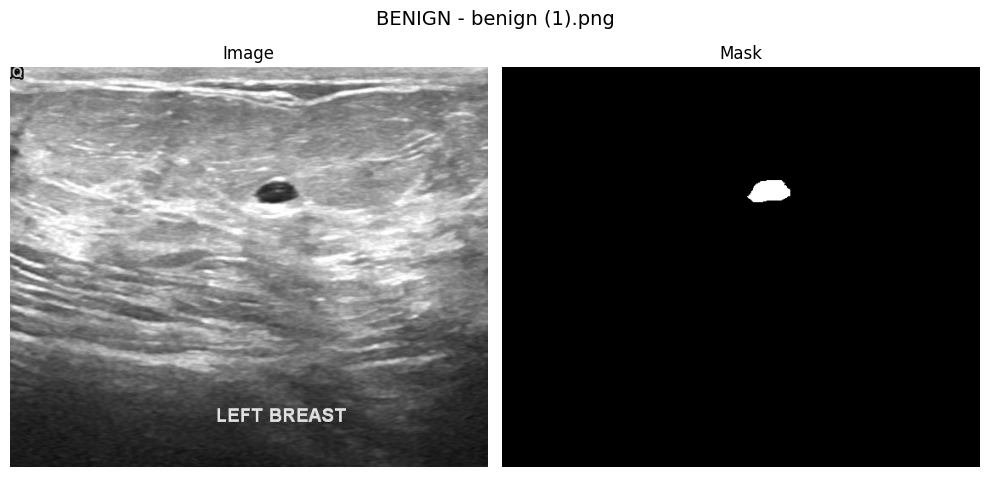

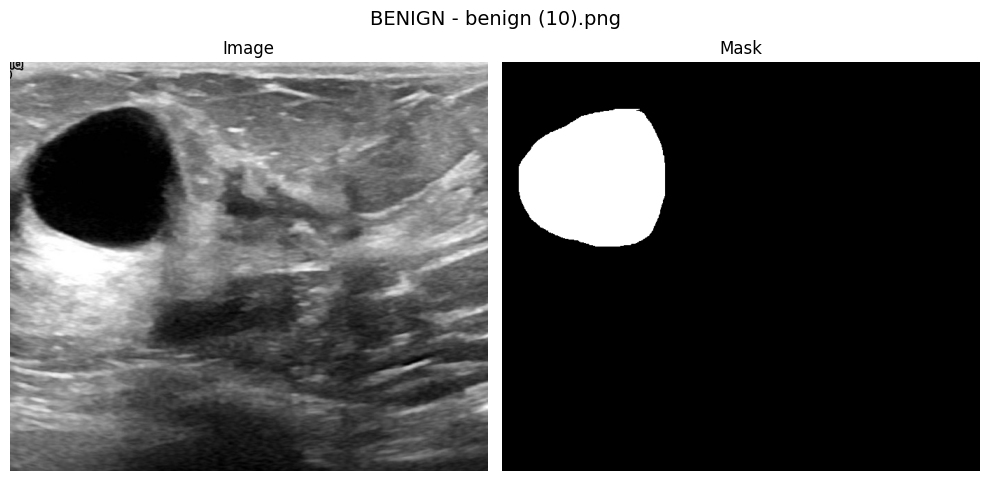

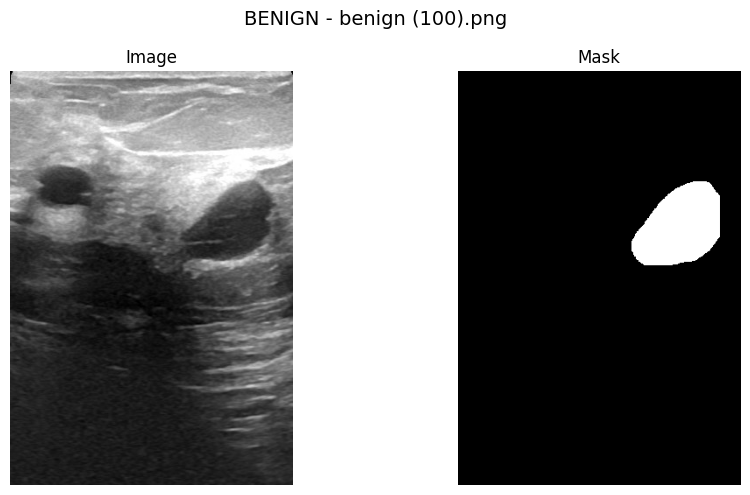


📁 Class: malignant


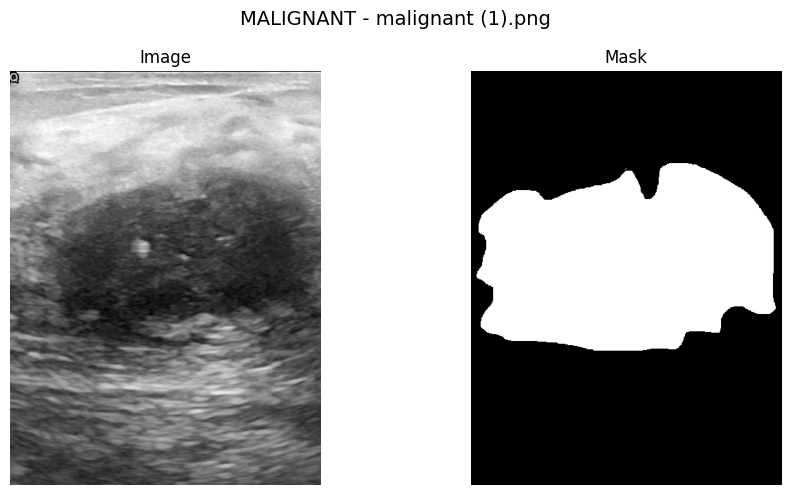

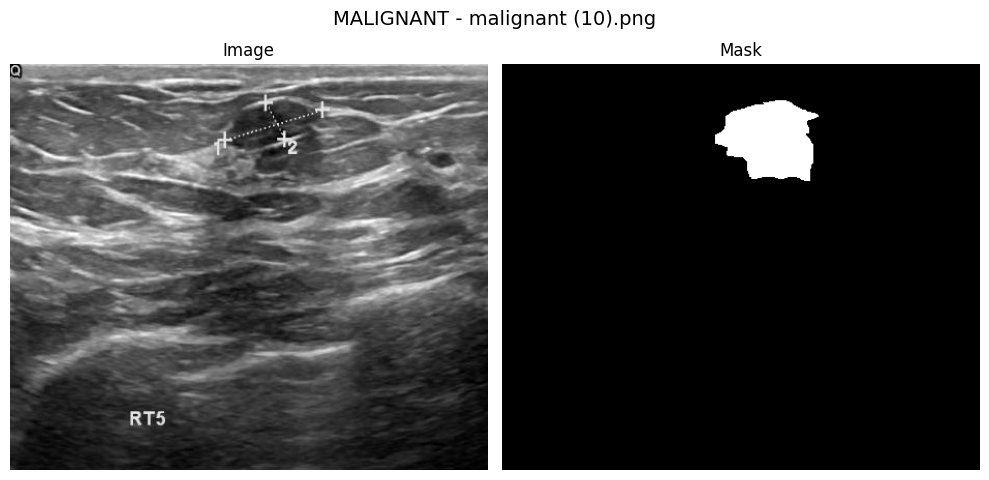

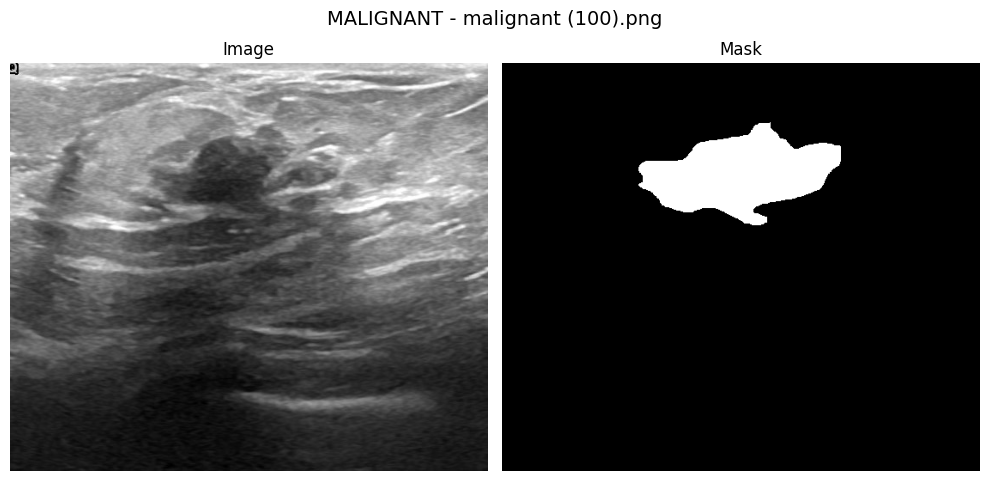


📁 Class: normal


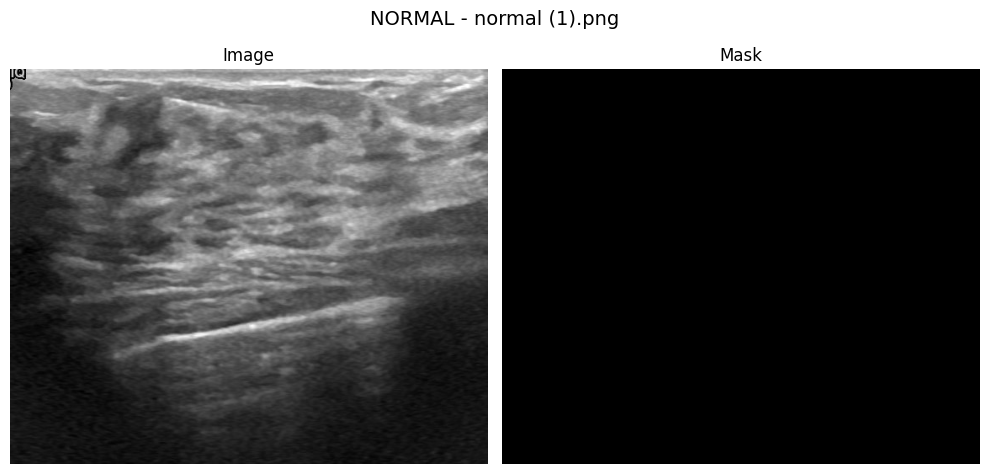

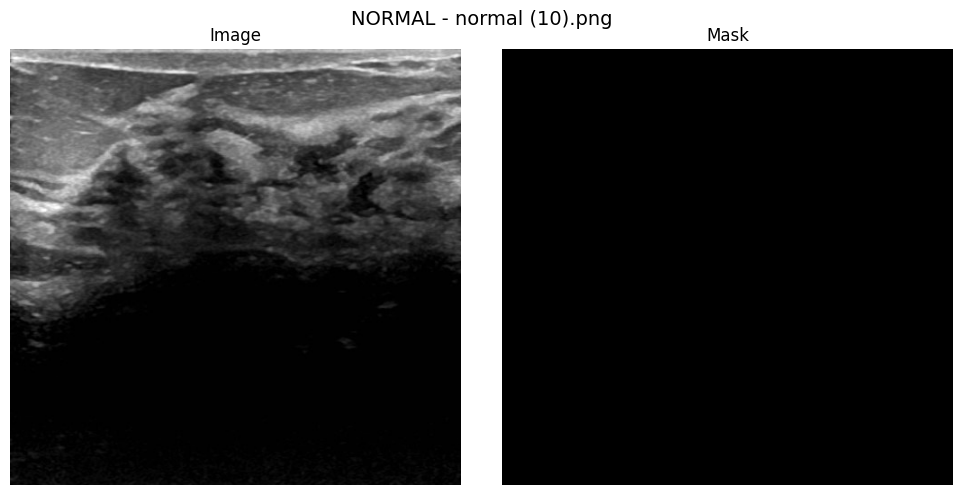

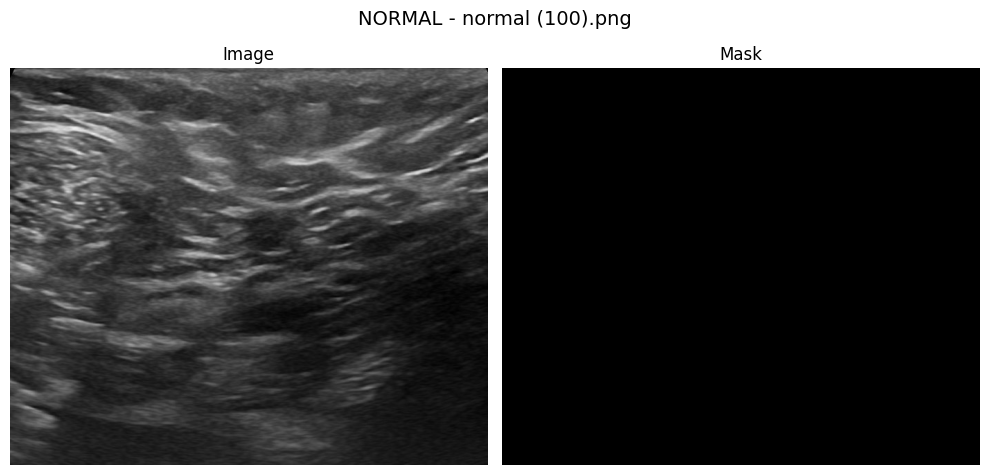

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

base_dir = "ultrasound_data/Dataset_BUSI_with_GT"

# Function to visualize n images and their masks from each class
def visualize_images_and_masks(dataset_dir, num_images=3):
    class_folders = ['benign', 'malignant', 'normal']

    for class_name in class_folders:
        print(f"\n📁 Class: {class_name}")
        class_path = os.path.join(dataset_dir, class_name)
        files = sorted([f for f in os.listdir(class_path) if "_mask" not in f])[:num_images]

        for file in files:
            img_path = os.path.join(class_path, file)
            mask_path = img_path.replace(".png", "_mask.png")

            img = Image.open(img_path)
            mask = Image.open(mask_path)

            plt.figure(figsize=(10, 5))
            plt.suptitle(f"{class_name.upper()} - {file}", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.title("Image")
            plt.imshow(img)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Mask")
            plt.imshow(mask, cmap='gray')  # can also use 'gray' or 'viridis'
            plt.axis('off')

            plt.tight_layout()
            plt.show()

print("🧾 Image Counts:")
for cls in ['benign', 'malignant', 'normal']:
    count = len([f for f in os.listdir(os.path.join(base_dir, cls)) if "_mask" not in f])
    print(f"- {cls}: {count} images")

visualize_images_and_masks(base_dir, num_images=3)


📁 Class: benign


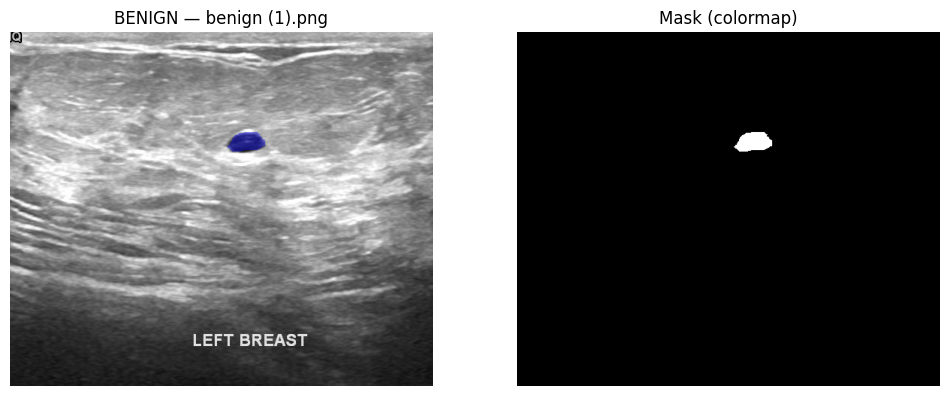

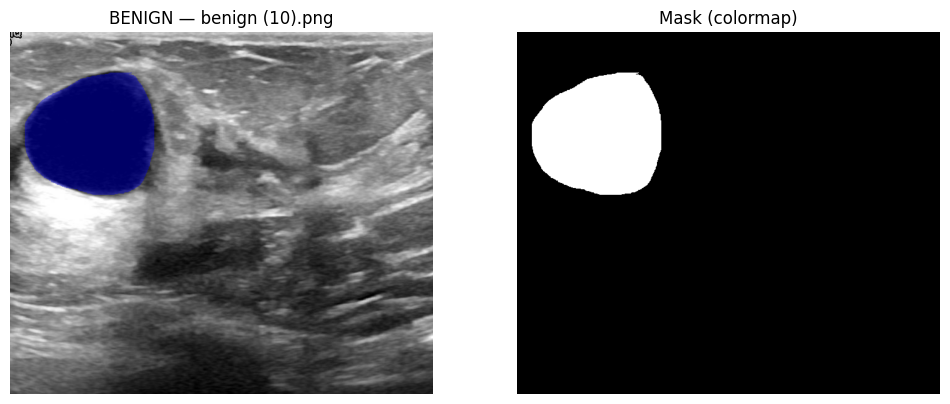

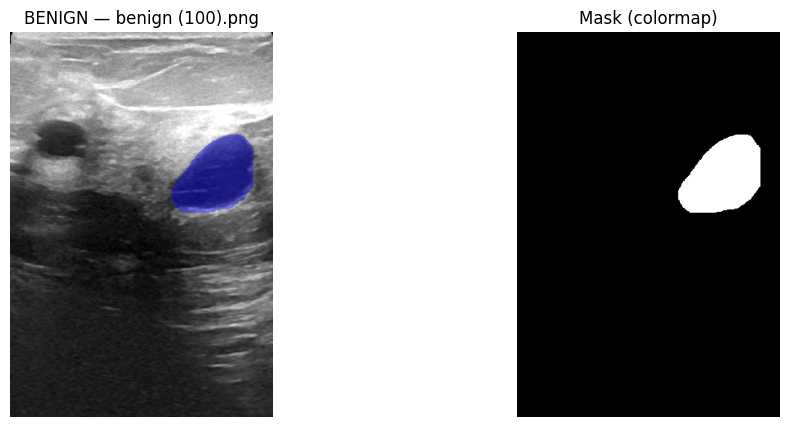


📁 Class: malignant


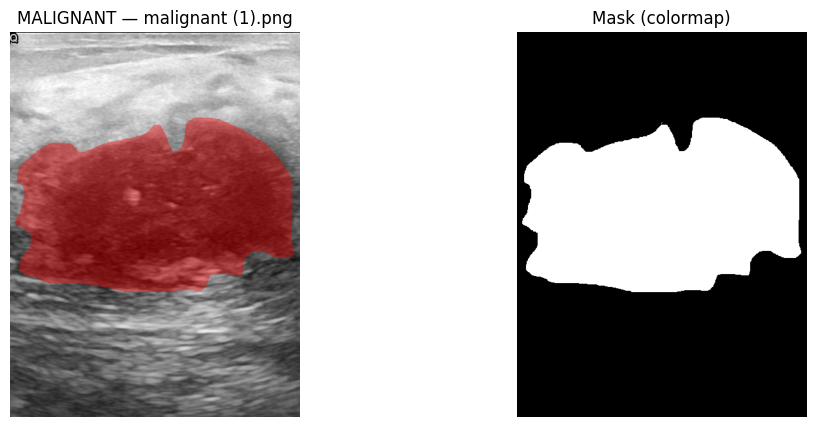

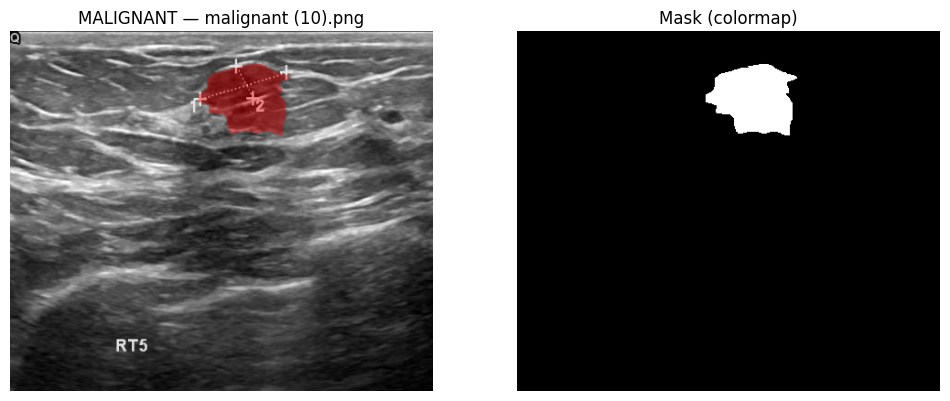

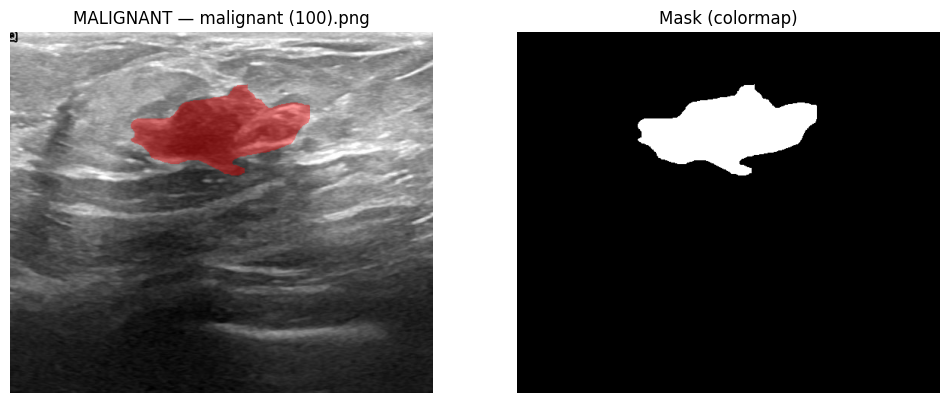


📁 Class: normal


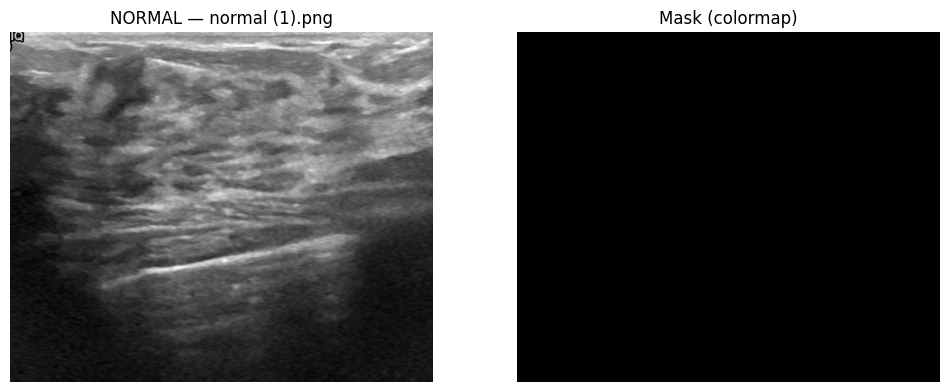

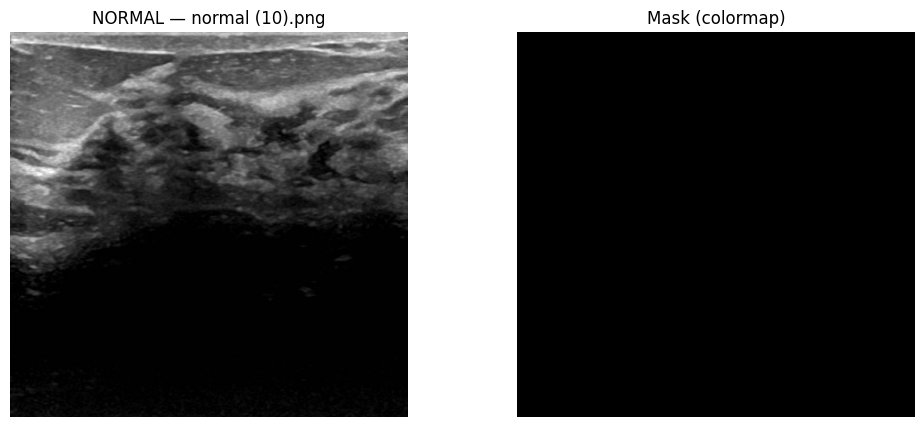

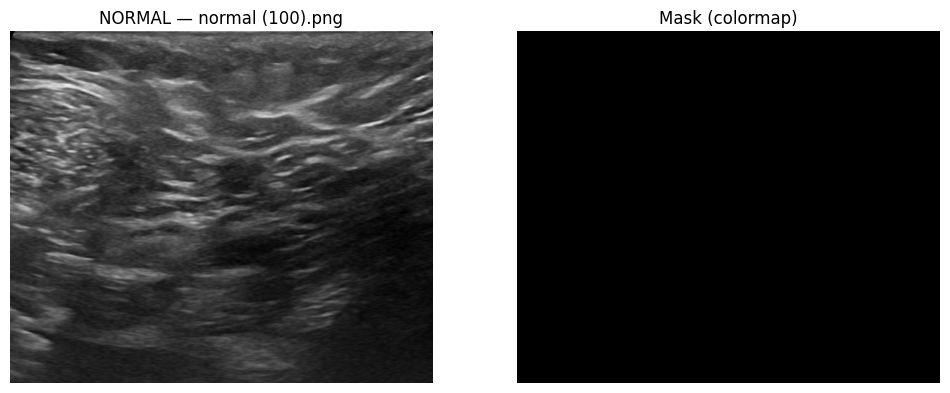

In [4]:
# Class colors for overlay: class_name -> RGB color
CLASS_COLORS = {
    'benign': [0, 0, 255],      # Blue
    'malignant': [255, 0, 0],   # Red
    'normal': [0, 255, 0]       # Green (unused, just for consistency)
}

def overlay_mask_on_image_busi_colored(dataset_dir, num_images=3, alpha=0.5):
    class_folders = ['benign', 'malignant', 'normal']

    for class_name in class_folders:
        print(f"\n📁 Class: {class_name}")
        class_path = os.path.join(dataset_dir, class_name)

        image_files = sorted([f for f in os.listdir(class_path) if "_mask" not in f])[:num_images]
        color = CLASS_COLORS[class_name]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            mask_path = img_path.replace(".png", "_mask.png")

            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            img_np = np.array(img)
            mask_np = np.array(mask)

            overlay = img_np.copy()
            overlay[mask_np > 0] = color  # color mask area

            # Alpha blend overlay
            blended = ((1 - alpha) * img_np + alpha * overlay).astype(np.uint8)

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"{class_name.upper()} — {img_file}")
            plt.imshow(blended)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Mask (colormap)")
            plt.imshow(mask_np, cmap='gray')  # Better visual contrast
            plt.axis('off')

            plt.show()

# Call the function
overlay_mask_on_image_busi_colored(base_dir, num_images=3, alpha=0.4)


# Segmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

2025-06-01 23:56:34.112501: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 23:56:34.318225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 23:56:34.459271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748800594.601127    6895 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748800594.643265    6895 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748800595.023948    6895 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Class label mapping
CLASS_MAP = {'benign': 1, 'malignant': 2, 'normal': 0}

def load_busi_dataset(base_dir):
    images = []
    masks = []

    for class_name, class_label in CLASS_MAP.items():
        class_dir = os.path.join(base_dir, class_name)
        for filename in os.listdir(class_dir):
            if "_mask" not in filename:
                img_path = os.path.join(class_dir, filename)
                mask_path = img_path.replace(".png", "_mask.png")

                img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
                mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")

                img_np = np.array(img) / 255.0
                mask_np = np.array(mask)
                if class_label != 0:
                    mask_np[mask_np > 0] = class_label
                else:
                    mask_np[:, :] = 0  # Ensure normal class masks are all background

                images.append(img_np)
                masks.append(mask_np)

    # Convert to NumPy arrays
    images = np.array(images)
    masks = np.expand_dims(np.array(masks), axis=-1)  # Add channel dimension

    return images, masks


images, masks = load_busi_dataset(base_dir)
print(f"✅ Loaded {len(images)} images and masks.")

✅ Loaded 780 images and masks.


In [ ]:
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 3

# Convert masks to one-hot encoding
masks = to_categorical(masks.squeeze(-1), num_classes=NUM_CLASSES)

# U-Net model's output is shaped like:
# [batch_size, height, width, NUM_CLASSES]
# with a softmax activation along the last axis. This means:
# Each pixel’s prediction is a probability distribution over NUM_CLASSES.
# Example: For 3 classes, a pixel might output [0.1, 0.7, 0.2].

# Loss functions like dice_loss and categorical_crossentropy compare probability distributions, not integer labels.
# So if you directly feed integer-labeled masks into dice_loss or the model's output layer, you get shape mismatches like:

# y_pred: (16, 224, 224, 3)
# y_true: (16, 224, 224, 1) ❌

In [8]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.3, random_state=42, stratify=masks.reshape(len(masks), -1).max(axis=1))
# Why stratify=masks.reshape(len(masks), -1).max(axis=1)?
# This ensures the split has a balanced number of each class (based on max label in mask) across training and validation sets — even though you have separate folders per class.

print("📊 Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

📊 Shapes:
X_train: (546, 224, 224, 3)
y_train: (546, 224, 224, 3)
X_val: (234, 224, 224, 3)
y_val: (234, 224, 224, 3)


In [9]:
def unet_model(input_size=(224, 224, 3), num_classes=3):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.3)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # softmax for multi-class

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

`K` is **Keras backend**, imported as:

```python
import tensorflow.keras.backend as K
```

### ✅ What is Keras Backend?

`K` provides a set of **low-level tensor operations** that work behind the scenes of high-level Keras layers and models. Think of it as a wrapper around TensorFlow functions (or Theano, historically), allowing operations like:

* `K.sum()` → sum of tensor elements
* `K.flatten()` → flatten tensor to 1D
* `K.mean()`, `K.max()`, `K.dot()` → tensor math
* `K.cast()`, `K.shape()` → tensor conversions & introspection

---


Here's how to interpret the metrics you're using for your segmentation model:

---

### ✅ `dice_coef` (Dice Coefficient)

* **Range**: 0 to 1
* **Goal**: **Higher is better**
* **Ideal**: 1.0 (perfect overlap)
* **What it means**:
  Measures the overlap between the predicted mask and the ground truth. It's especially useful for **imbalanced class problems** like medical image segmentation.

  Formula:

  $$
  \text{Dice} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
  $$

  where $A$ is the predicted mask and $B$ is the ground truth.

---

### ❌ `dice_loss`

* **Range**: 0 to 1
* **Goal**: **Lower is better**
* **Ideal**: 0.0 (no loss → perfect match)
* **What it means**:
  It's just `1 - dice_coef`, so minimizing this increases the Dice score.

---

### ✅ `iou_metric` (Intersection over Union)

* **Range**: 0 to 1
* **Goal**: **Higher is better**
* **Ideal**: 1.0
* **What it means**:
  Also called the **Jaccard index**, this measures the overlap divided by the union of predicted and true masks.

  Formula:

  $$
  \text{IoU} = \frac{|A \cap B|}{|A \cup B|}
  $$

---

### ✅ Summary

| Metric       | Ideal Value | Interpretation          | You Want |
| ------------ | ----------- | ----------------------- | -------- |
| `dice_coef`  | 1.0         | High overlap            | High     |
| `dice_loss`  | 0.0         | Low difference          | Low      |
| `iou_metric` | 1.0         | High intersection/union | High     |

---

### 🔍 Tip for Model Monitoring

During training:

* If `dice_coef` and `iou_metric` are **increasing** → your model is improving.
* If `dice_loss` is **decreasing** → your model is learning better masks.

During validation:

* If `dice_coef` and `iou_metric` plateau or decrease while training improves, you're **overfitting**.

In [11]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 3

model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef, iou_metric])
model.summary()

E0000 00:00:1748800742.271317    6895 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748800742.275070    6895 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[

 Total params: 1,968,547 (7.51 MB)

 Trainable params: 1,965,603 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

mask_datagen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

seed = 1 # using the same seed ensures matching transformations are applied to both the image and its corresponding mask.
image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=seed)

train_generator = zip(image_generator, mask_generator)

# However, this still creates a zip object, which is a generator. zip(...) returns a lazy iterable that can’t restart once exhausted.
# You need to wrap the zip into a generator function:

def combined_generator():
    for (img, mask) in train_generator:
        yield (img, mask)
        
#This makes it compatible with model.fit(...), which expects a generator or tf.data.Dataset when using data pipelines.
# more robust version:
# def combined_generator():
#     while True:
#         image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=seed)
#         mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=seed)
#         for (img, mask) in zip(image_generator, mask_generator):
#             yield (img, mask)
# If you only call model.fit() once:
# Your current version is fine.
# If you plan to call model.fit() multiple times, or want to avoid generator exhaustion issues:
# Use the robust version.

In [13]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model/unet_busi_best_model.h5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model/training_log.csv', append=True)
callbacks_list = [earlystopper, checkpointer, csv_logger]

In [14]:
steps_per_epoch = len(X_train) // BATCH_SIZE

In [15]:
history = model.fit(
    combined_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)

Epoch 1/10


2025-06-02 00:00:32.448753: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-02 00:00:32.570232: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-02 00:00:32.777531: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-02 00:00:32.833995: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-06-02 00:00:32.933266: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - dice_coef: 0.4727 - iou_metric: 0.3168 - loss: 0.5273
Epoch 1: val_loss improved from inf to 0.16646, saving model to model/unet_busi_best_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 405s 11s/step - dice_coef: 0.4755 - iou_metric: 0.3193 - loss: 0.5245 - val_dice_coef: 0.8316 - val_iou_metric: 0.7119 - val_loss: 0.1665
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - dice_coef: 0.7092 - iou_metric: 0.5498 - loss: 0.2900
Epoch 2: val_loss improved from 0.16646 to 0.07526, saving model to model/unet_busi_best_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 369s 11s/step - dice_coef: 0.7098 - iou_metric: 0.5505 - loss: 0.2894 - val_dice_coef: 0.9225 - val_iou_metric: 0.8565 - val_loss: 0.0753
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - dice_coef: 0.7879 - iou_metric: 0.6503 - loss: 0.2097
Epoch 3: val_loss improved from 0.07526 to 0.06836, saving model to model/unet_busi_best_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 358s 11s/step - dice_coef: 0.7882 - iou_metric: 0.6507 - loss: 0.2095 - val_dice_coef: 0.9293 - val_iou_metric: 0.8684 - val_loss: 0.0684
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - dice_coef: 0.8328 - iou_metric: 0.7139 - loss: 0.1648
Epoch 4: val_loss did not improve from 0.06836
34/34 ━━━━━━━━━━━━━━━━━━━━ 362s 11s/step - dice_coef: 0.8331 - iou_metric: 0.7143 - loss: 0.1646 - val_dice_coef: 0.9256 - val_iou_metric: 0.8617 - val_loss: 0.0723
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - dice_coef: 0.8621 - iou_metric: 0.7581 - loss: 0.1358
Epoch 5: val_loss did not improve from 0.06836
34/34 ━━━━━━━━━━━━━━━━━━━━ 353s 10s/step - dice_coef: 0.8624 - iou_metric: 0.7586 - loss: 0.1355 - val_dice_coef: 0.8374 - val_iou_metric: 0.7213 - val_loss: 0.1563
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - dice_coef: 0.8825 - iou_metric: 0.7900 - loss: 0.1179 
Epoch 6: val_loss did not improve from 0.06836
34/34 ━━━━━━━━━━━━━━━━━━━━ 377s 11s/step - dice

34/34 ━━━━━━━━━━━━━━━━━━━━ 349s 10s/step - dice_coef: 0.9057 - iou_metric: 0.8283 - loss: 0.0927 - val_dice_coef: 0.9331 - val_iou_metric: 0.8751 - val_loss: 0.0639
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - dice_coef: 0.9173 - iou_metric: 0.8477 - loss: 0.0827
Epoch 9: val_loss did not improve from 0.06387
34/34 ━━━━━━━━━━━━━━━━━━━━ 307s 9s/step - dice_coef: 0.9174 - iou_metric: 0.8478 - loss: 0.0826 - val_dice_coef: 0.9187 - val_iou_metric: 0.8502 - val_loss: 0.0775
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - dice_coef: 0.9190 - iou_metric: 0.8506 - loss: 0.0814
Epoch 10: val_loss did not improve from 0.06387
34/34 ━━━━━━━━━━━━━━━━━━━━ 362s 11s/step - dice_coef: 0.9192 - iou_metric: 0.8510 - loss: 0.0812 - val_dice_coef: 0.9303 - val_iou_metric: 0.8699 - val_loss: 0.0679
Restoring model weights from the end of the best epoch: 8.


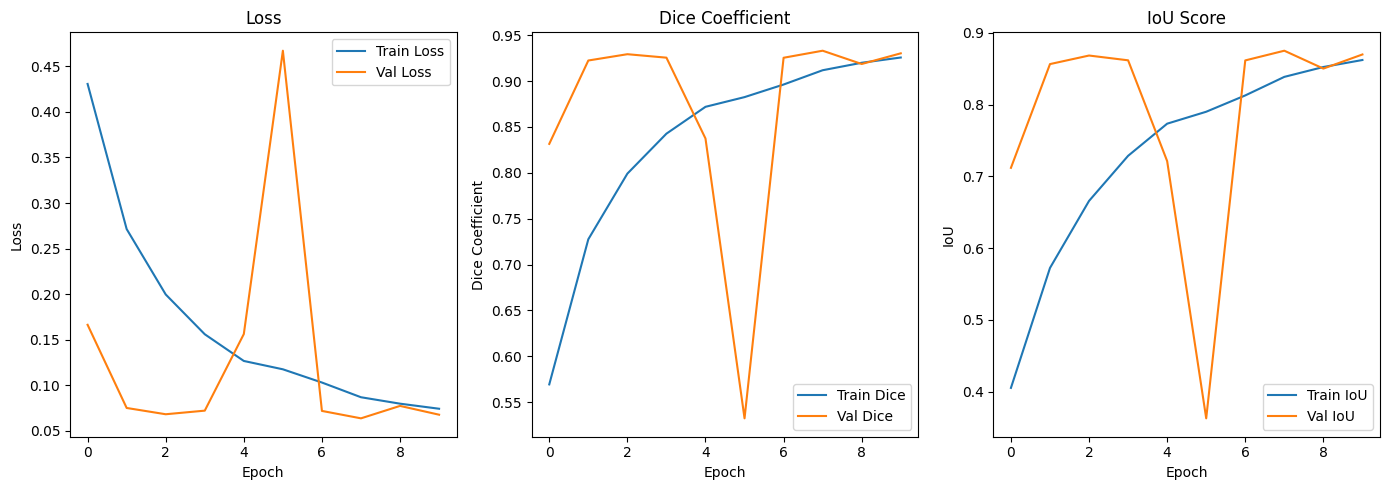

In [16]:
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Dice Coefficient plot
plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU plot
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


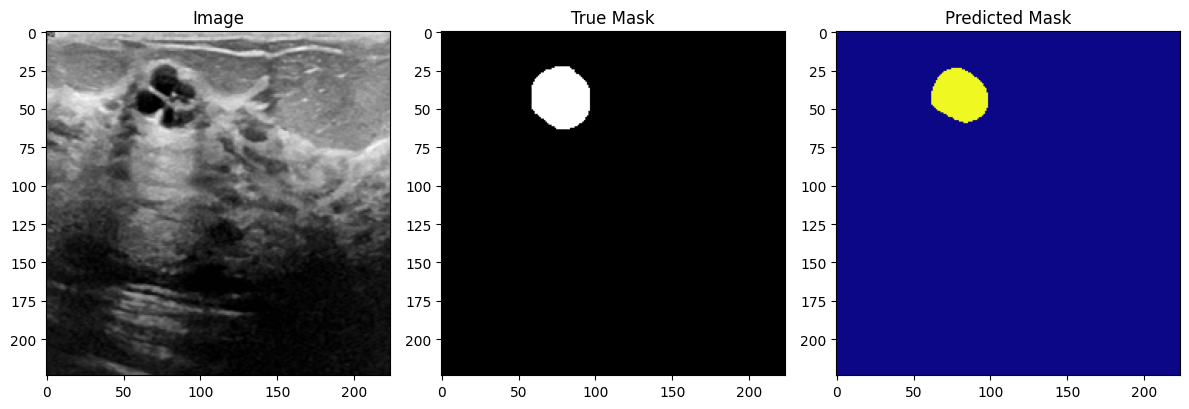

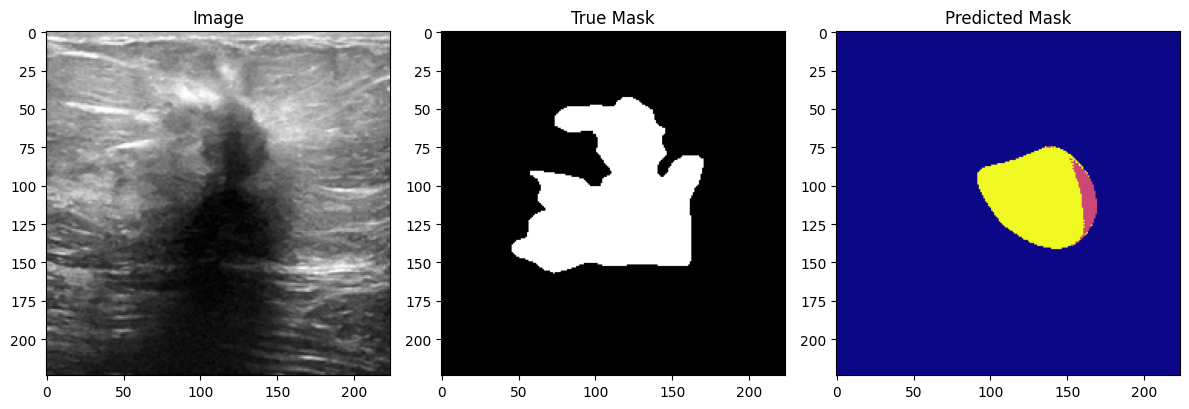

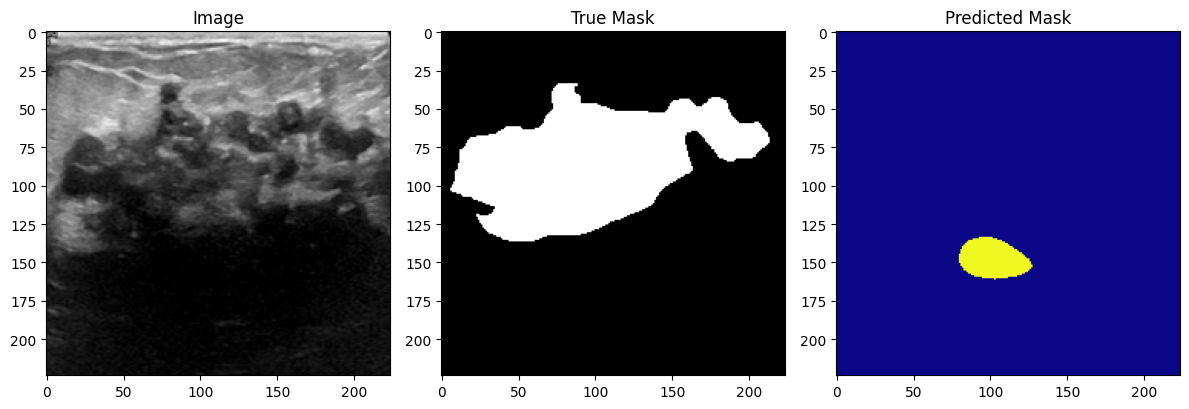

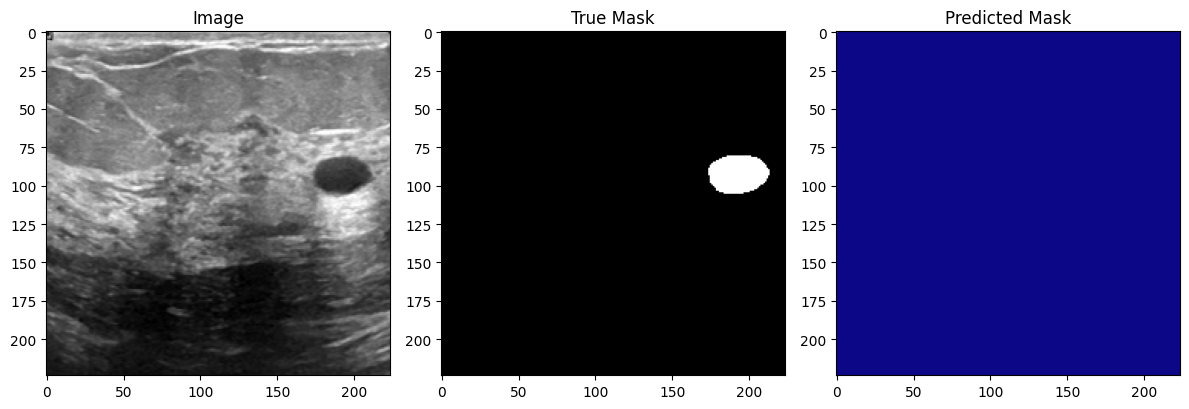

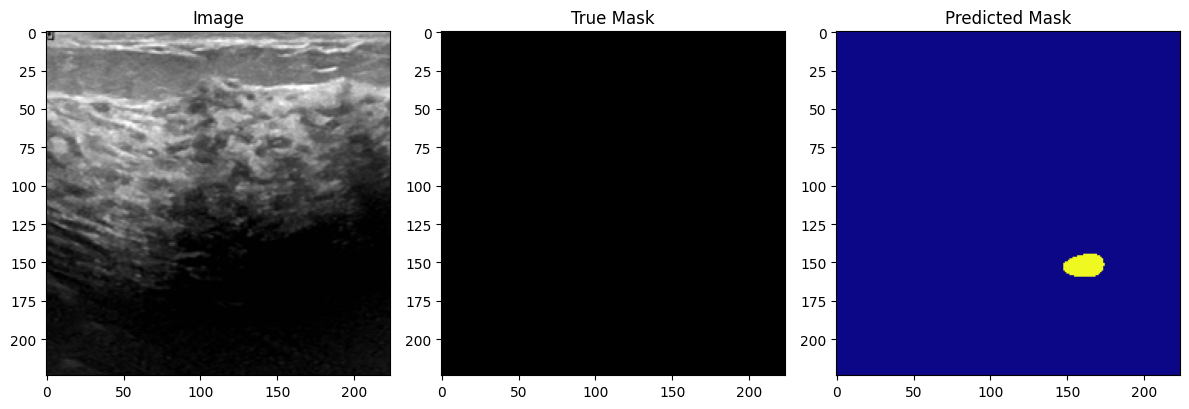

In [17]:
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        # True mask (convert from one-hot to class index if necessary)
        true_mask = np.argmax(y_val[i], axis=-1) if y_val.shape[-1] > 1 else y_val[i].squeeze()
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap='gray')

        # Predicted mask (convert from one-hot probabilities to class indices)
        pred_mask = np.argmax(preds[i], axis=-1) if preds.shape[-1] > 1 else preds[i].squeeze()
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='plasma')

        plt.tight_layout()
        plt.show()

visualize_predictions(num_images=5)

## Looks like I will have to train it for moreeeeeeee epochs!

# Prediction on a single image

In [19]:
def visualize_prediction_from_path(img_path, alpha=0.5, cmap='plasma'): # gray is better for binary, plasma or viridis works well for multiple classes.
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    img_np = np.array(img) / 255.0  # normalize to [0,1]

    pred = model.predict(np.expand_dims(img_np, axis=0))[0]  # shape: (H, W, NUM_CLASSES)
    
    # Convert prediction to class indices
    pred_class = np.argmax(pred, axis=-1)  # shape: (H, W)

    # Apply colormap to class indices
    color_mask = plt.get_cmap(cmap)(pred_class / (NUM_CLASSES - 1))[:, :, :3]  # Normalize to [0,1]

    # Overlay prediction on original image
    overlay = (1 - alpha) * img_np + alpha * color_mask
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout() # plt.tight_layout() is a Matplotlib function that automatically adjusts the spacing between subplots
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


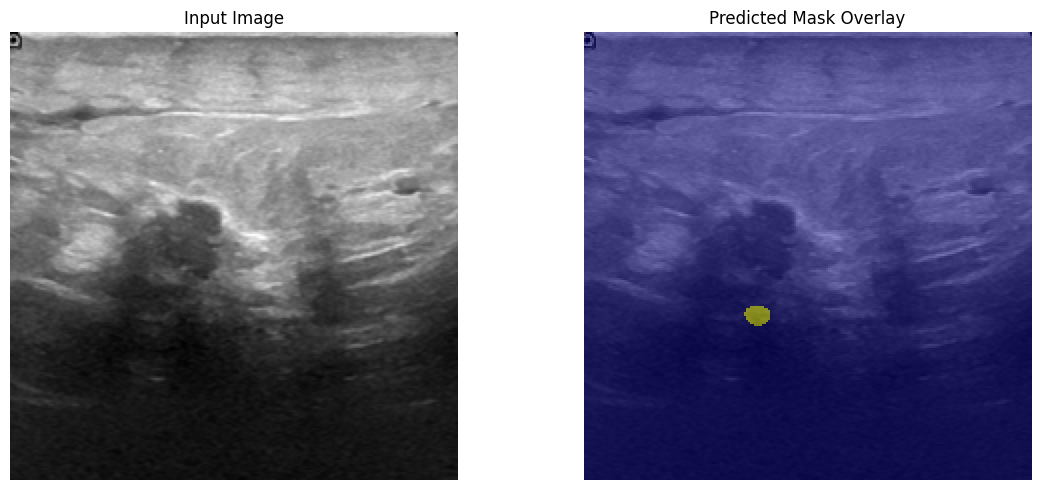

In [20]:
visualize_prediction_from_path('ultrasound_data/Dataset_BUSI_with_GT/malignant/malignant (7).png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


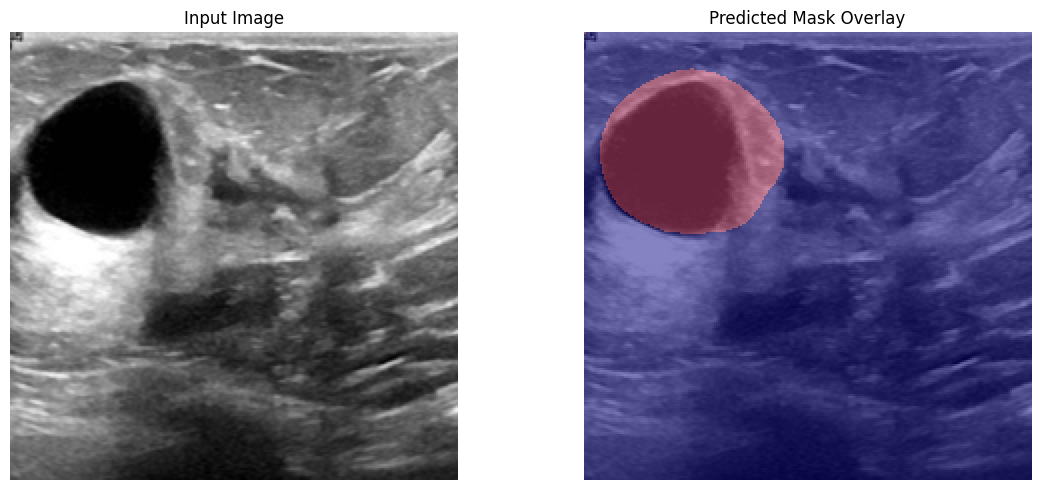

In [21]:
visualize_prediction_from_path('ultrasound_data/Dataset_BUSI_with_GT/benign/benign (10).png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


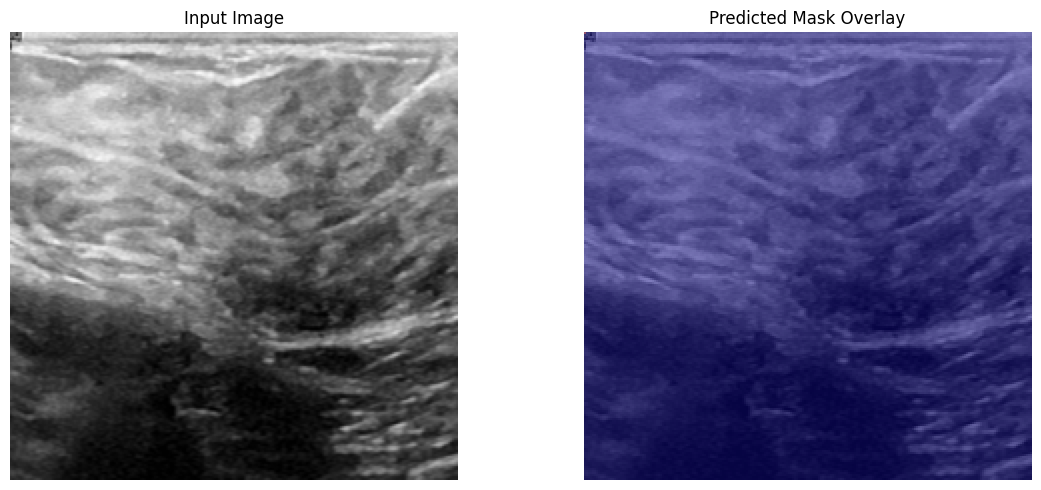

In [22]:
visualize_prediction_from_path('ultrasound_data/Dataset_BUSI_with_GT/normal/normal (14).png')